# Graph classification.
Vediamo come applicare le Graph Neural Network (GNN) per il task di classificazione. Dato un dataset di grafi con determinate caratteristiche strutturali, facciamo l'embedding di un intero grafo. Successivamente effettuiamo una classificazione dei grafi.

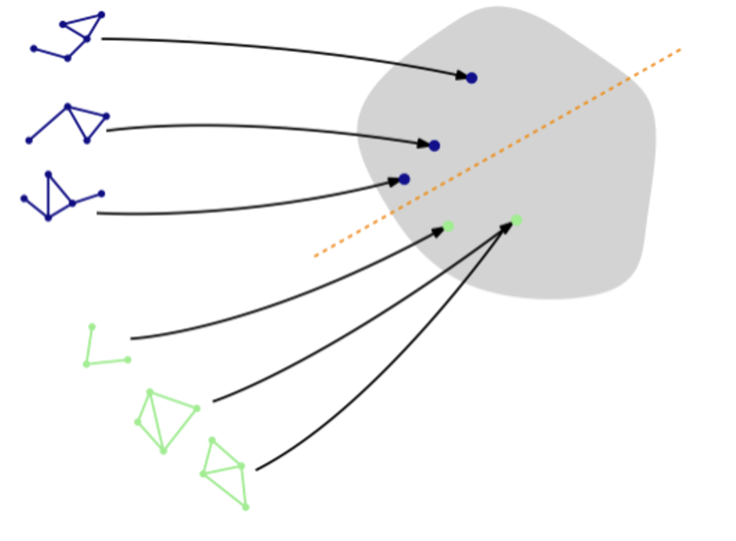


In [1]:
import torch
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T



transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

#dataset = TUDataset(path, name='MUTAG', transform=transform)

dataset = TUDataset(root='data1/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Numero di grafi: {len(dataset)}')
print(f'Numero di feature: {dataset.num_features}')
print(f'Numero di classi: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Numero di nodi: {data.num_nodes}')
print(f'Numero di archi: {data.num_edges}')
print(f'Grado medio dei nodi: {data.num_edges / data.num_nodes:.2f}')
print(f'Ci sono nodi isolati: {data.has_isolated_nodes()}')
print(f'Ci sono self loop: {data.has_self_loops()}')
print(f'E\' non direzionato: {data.is_undirected()}')


Dataset: MUTAG(188):
Numero di grafi: 188
Numero di feature: 7
Numero di classi: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Numero di nodi: 17
Numero di archi: 38
Grado medio dei nodi: 2.24
Ci sono nodi isolati: False
Ci sono self loop: False
E' non direzionato: True


## MUTAG 
Il dataset MUTAG dataset contiene 188 compound chimici divisi in due classi in base al loro effetto mutagenico su un batterio. 

Il dato chimico è stato ottenuto da http://cdb.ics.uci.edu e convertito in grafi dove i vertici rappresentano gli atomi e gli archi rappresentano i legami chimici. Gli atomi di itrogeno espliciti sono stati rimossi e i vertici sono etichettati  dai tipi di aotmi  gli archi dal tipo di legame (single, double, triple o aromatic).


In [2]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Numero di grafi nel training set: {len(train_dataset)}')
print(f'Numero di grafi nel test set : {len(test_dataset)}')

Numero di grafi nel training set: 150
Numero di grafi nel test set : 38


In [3]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Numero di grafi nel batch corrente: {data.num_graphs}')
    print(data)
    print()

Step 1:
Numero di grafi nel batch corrente: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Numero di grafi nel batch corrente: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Numero di grafi nel batch corrente: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



In [10]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Embedding dei nodi 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2.  pooling
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. classificazione lineare
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #print(x.shape)
        #print(dataset.num_node)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iteriamo nei batch sui dati di training 
         out = model(data.x, data.edge_index, data.batch)  # foward
         loss = criterion(out, data.y)  # loss.
         loss.backward()  # gradiente.
         optimizer.step()  # Update parametri in base al gradiente.
         optimizer.zero_grad()  # azzeriamo il gradiente
         return loss

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iteriamo nei batch sui dati di training/testing.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # selezioniamo la classe con la piu' alta probaiblità.
         correct += int((pred == data.y).sum())  # verifica della corretteza.
     return correct / len(loader.dataset)  # percentuale di correttezza.


for epoch in range(1, 150):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6924
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6562
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.5881
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6134
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6069
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6500
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6277
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6705
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6627
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6542
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6317
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6228
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6035
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6268
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.5582
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.5409
Epoch: 0

In [6]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels,aggr="add")
        self.conv2 = GraphConv(hidden_channels, hidden_channels,aggr="add")
        self.conv3 = GraphConv(hidden_channels, hidden_channels,aggr="add")
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=128)
print(model)

GNN(
  (conv1): GraphConv(7, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
#model = GNN(hidden_channels=64)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6582
Epoch: 002, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 0.9285
Epoch: 003, Train Acc: 0.3533, Test Acc: 0.2632, Loss: 12.3404
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 2.5259
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6648
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6750
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.7574
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.5736
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.5698
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6081
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368, Loss: 0.6363
Epoch: 012, Train Acc: 0.6533, Test Acc: 0.7368, Loss: 0.6074
Epoch: 013, Train Acc: 0.7000, Test Acc: 0.7632, Loss: 0.6156
Epoch: 014, Train Acc: 0.7000, Test Acc: 0.7632, Loss: 0.6255
Epoch: 015, Train Acc: 0.6533, Test Acc: 0.7368, Loss: 0.5903
Epoch: 016, Train Acc: 0.6533, Test Acc: 0.7368, Loss: 0.5153
Epoch: 